<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/MultiOutputRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings;warnings.simplefilter('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression,Lasso,Ridge
from xgboost import XGBRegressor
import xgboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# some function

In [0]:
def mape_vectorized_v2(a, b):
    a = np.array(a)
    b = np.array(b) 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [0]:
def metric(y_t,y_p,name):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'MAPE':mape_vectorized_v2(y_t,y_p)
         }
  return pd.DataFrame(res,index=[name])

In [0]:
def rmse(y_t,y_p):
  return sqrt(mean_squared_error(y_t,y_p))
rmse_score = make_scorer(rmse)

In [0]:
def modeling(my_model,train,test):
  model = MultiOutputRegressor(my_model)
  model.fit(train[features],train[y_columns])
  y_pred = pd.DataFrame(model.predict(test[features]),columns=y_columns)
  res = pd.DataFrame()
  for y_name in y_columns:
    res = res.append(metric(test[y_name],y_pred[y_name],y_name))
  return res,model

# load data

In [0]:
dataset = {}
dataset['train_4521'] = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0)
dataset['test_170'] = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)
dataset['test_200'] = test_250.loc[test_250.index %5 != 0]
dataset['test_50'] = test_250.loc[test_250.index %5 == 0].drop(95,axis=0)

In [7]:
for k in dataset.keys():
  dataset[k]['tag'] = k
  print(k,dataset[k].shape)

train_4521 (4521, 28)
test_170 (170, 28)
test_200 (200, 28)
test_50 (49, 28)


# cluster

In [0]:
def cut_NA(x):
  if x >= 36:
    return 1
  else:
    return 0

In [9]:
for k in dataset.keys():
  dataset[k]['cluster'] = dataset[k]['N+A'].apply(cut_NA)
  print(dataset[k]['cluster'].value_counts())

1    2555
0    1966
Name: cluster, dtype: int64
1    111
0     59
Name: cluster, dtype: int64
1    181
0     19
Name: cluster, dtype: int64
1    45
0     4
Name: cluster, dtype: int64


# features , y_columns

In [0]:
cols = dataset['train_4521'].columns.tolist()
features = cols[:4]
y_columns = cols[4:4+23]

# kdeplot

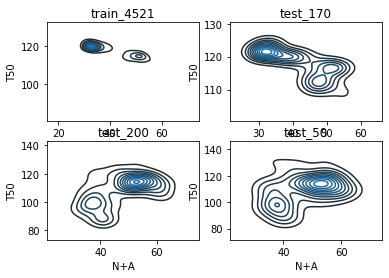

In [11]:
plt.figure()
plot_col = ['N+A','T50']
for i,k in enumerate(dataset.keys()):
  plt.subplot(2,2,i+1)
  sns.kdeplot(dataset[k][plot_col],label=k)
  plt.title(k)
  plt.xlabel('N+A')
  plt.ylabel('T50')
plt.show()  

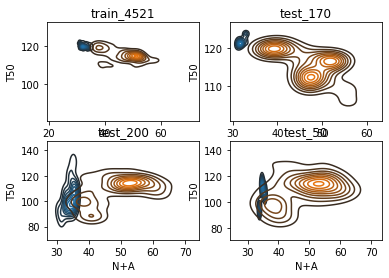

In [12]:
plt.figure()
plot_col = ['N+A','T50']
for i,k in enumerate(dataset.keys()):
  plt.subplot(2,2,i+1)
  sns.kdeplot(dataset[k].loc[dataset[k]['cluster'] == 0,plot_col],label=k+'_cluster_0')
  sns.kdeplot(dataset[k].loc[dataset[k]['cluster'] == 1,plot_col],label=k+'_cluster_1')
  plt.title(k)
  plt.xlabel('N+A')
  plt.ylabel('T50')
plt.show()  

# merge

In [13]:
full = pd.DataFrame()
for key,value in dataset.items():
  full = full.append(value)
full = full.reset_index(drop=True)
print(full.shape)
full.head()

(4940, 29)


,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,tag,cluster
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319,train_4521,0
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303,train_4521,0
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289,train_4521,0
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281,train_4521,0
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290,train_4521,0


# train test split

In [37]:
c1 = (full['tag'].isin(['train_4521']))
c2 = (full['tag']=='test_170')
train = full.loc[c1,:]
test = full.loc[c2,:]
print(train.shape)
print(test.shape)

(4521, 29)
(170, 29)


# features kdeplot

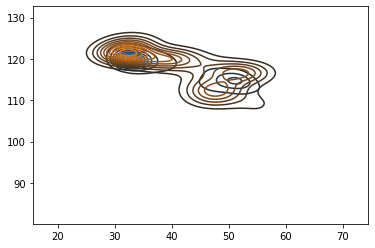

In [38]:
sns.kdeplot(train[plot_col],label='train')
sns.kdeplot(test[plot_col],label='test')

# y kdeplot

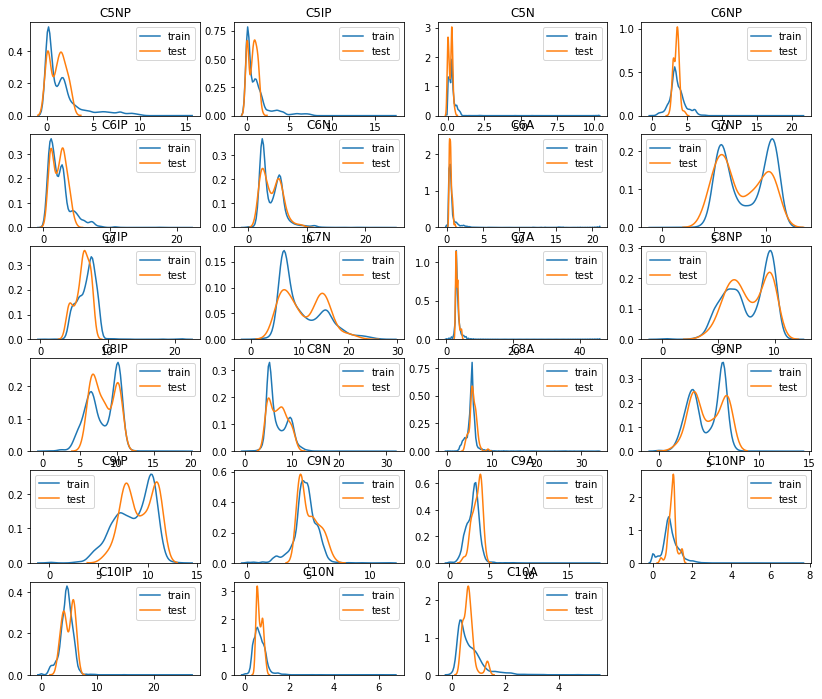

In [39]:
plt.figure(figsize=(14,12))
for i,y_name in enumerate(y_columns):
  plt.subplot(6,4,i+1)
  sns.kdeplot(train[y_name],label='train')
  sns.kdeplot(test[y_name],label='test')
  plt.title(y_name)
plt.show()

# modeling & metric

In [40]:
model = CatBoostRegressor(learning_rate = 0.1,n_estimators=100,verbose=0)
res,model = modeling(model,train,test)
res.loc['AVG'] = res.mean(axis=0)
res.style.background_gradient(axis=1)

,R2,RMSE,MAPE
C5NP,0.890189,0.28319,0.328134
C5IP,0.741585,0.260133,0.391908
C5N,0.905499,0.0420836,0.407218
C6NP,0.142407,0.374664,0.0779324
C6IP,0.882479,0.35833,0.108969
C6N,0.89134,0.545891,0.0547553
C6A,0.0419491,0.167227,0.239234
C7NP,0.976594,0.336466,0.0365473
C7IP,0.811422,0.479855,0.06463
C7N,0.984376,0.520904,0.0323519


# 預測結果比較

In [0]:
y_pred = model.predict(test[features])
y_pred = pd.DataFrame(y_pred,columns=y_columns)
y_test = test[y_columns].reset_index(drop=True)

In [42]:
y_pred.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.948323,0.715301,0.144237,3.483864,2.337574,3.747580,0.800524,7.994275,6.551812,9.732498,3.305307,7.684427,8.048532,7.191401,5.944933,4.851409,8.904074,4.821005,3.506446,1.152798,5.141567,0.686179,0.738290
1,0.143232,0.080899,0.019247,3.336390,1.101158,2.161299,0.385687,10.455013,7.734381,6.333086,2.942855,9.644412,10.210692,4.972490,5.831339,6.609361,10.695534,4.457929,3.819115,1.102179,5.911837,0.659690,0.868596
2,0.101353,0.073626,0.013589,3.088424,1.085352,2.072278,0.359619,10.339229,7.695864,6.172831,2.884446,9.717391,10.272240,4.875669,5.475391,6.746528,10.828835,4.273515,3.768314,1.234942,6.116117,0.663820,0.973131
3,0.092719,0.050276,0.016623,3.498809,1.154634,2.155182,0.387981,10.461407,7.609147,6.048269,2.912889,9.854983,10.387374,4.883098,5.858927,6.783267,10.882995,4.173065,3.886915,1.081497,6.042156,0.601726,0.696953
4,0.153928,0.082049,0.018275,3.350658,1.101787,2.163041,0.401639,10.386057,7.692437,6.328726,2.965812,9.616366,10.188340,4.894957,6.003796,6.619301,10.682729,4.466250,3.867825,1.113288,5.991535,0.622841,0.859540


In [43]:
y_test.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597
1,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484
2,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456
3,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449
4,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463


# 預測線圖比較

In [44]:
diff = y_test-y_pred
total_loss = abs(diff).sum(axis=1).sort_values(ascending=False)
bad5 = total_loss.head(5)
good5 = total_loss.tail(5)
print(total_loss)

157    15.579095
156    14.584272
154    14.583672
155    14.072482
169    13.009383
         ...    
29      2.595185
41      2.590520
66      2.542466
65      2.513832
60      2.508321
Length: 170, dtype: float64


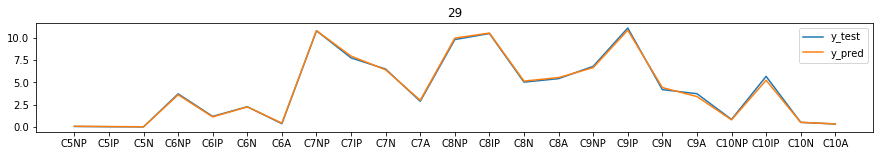

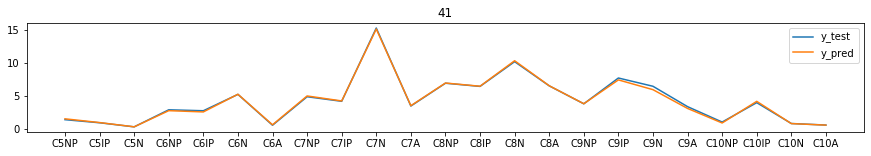

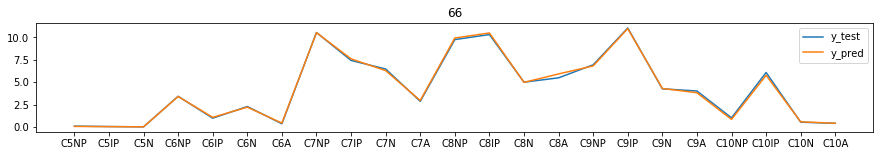

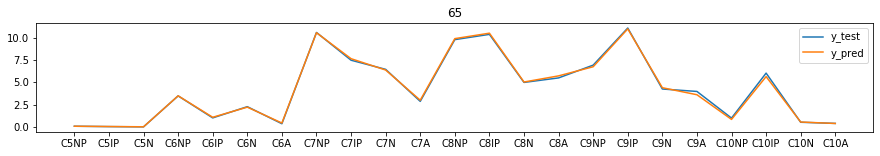

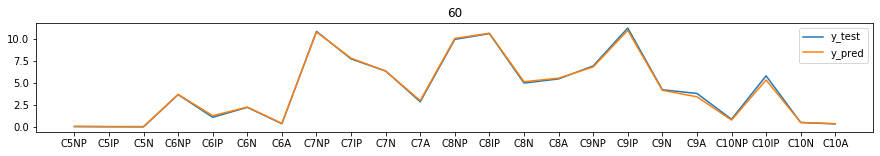

In [45]:
for i in good5.index:
  fig = plt.figure(figsize=(15,2))
  plt.plot(y_test.iloc[i,:],label='y_test')
  plt.plot(y_pred.iloc[i,:],label='y_pred')
  plt.title(i)
  plt.legend()
  plt.show()

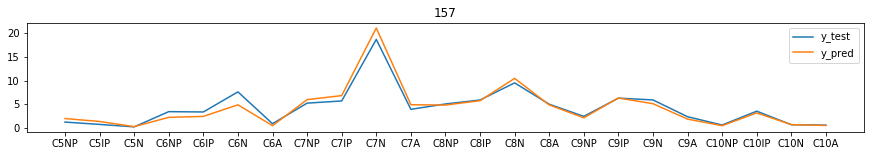

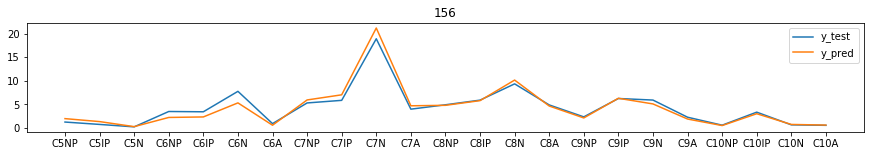

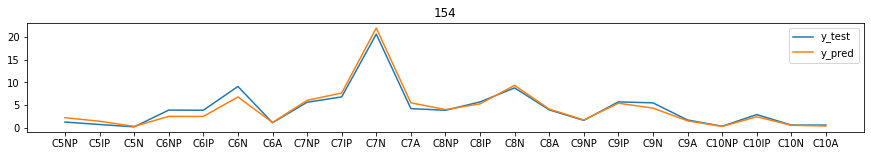

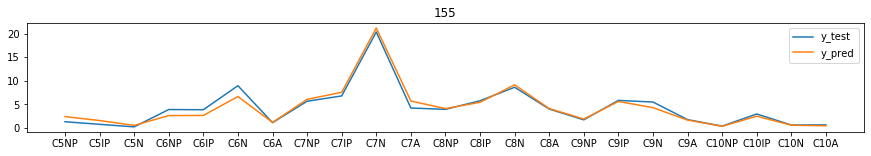

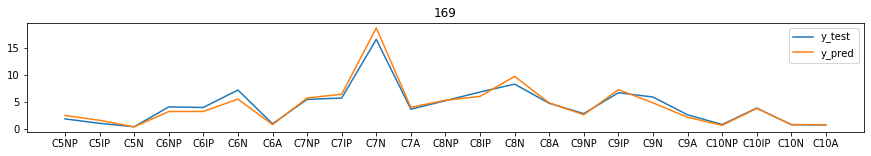

In [46]:
for i in bad5.index:
  fig = plt.figure(figsize=(15,2))
  plt.plot(y_test.iloc[i,:],label='y_test')
  plt.plot(y_pred.iloc[i,:],label='y_pred')
  plt.title(i)
  plt.legend()
  plt.show()